### Examine whether employment or low income status has a higher correlation with crime in Toronto neighbourhoods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [2]:
toronto2014 = pd.read_csv("wellbeing_toronto_2014.csv")
toronto2014.set_index('Neighbourhood', inplace=True)
toronto2014.head(3)

,NeighbourhoodId,TotalArea,TotalPopulation,LabourForceCategory,InLabourForce,Unemployed,NotInLabourForce,LowIncomeFamilies,LowIncomePopulation,Assaults,SexualAssaults,BreakEnters,Robberies,VehicleThefts,Thefts,Murders,Arsons
Neighbourhood,,,,,,,,,,,,,,,,,
West Humber-Clairville,1,30.09,33312,27365,17610,1750,9755,3790,7590,259,31,131,82,316,38,3,2
Mount Olive-Silverstone-Jamestown,2,4.60,32954,24980,14655,2175,10320,5010,11540,213,16,34,81,42,3,1,1
Thistletown-Beaumond Heights,3,3.40,10360,8135,4825,530,3315,1080,2350,35,3,23,12,13,1,0,0


### Exploration

#### Feature Engineering - Definition of new features:
 1. Population Density is the a ward's population divided by its area in km2
 2. Property Crime is the total of reported crimes in categories Break & Enters, Robberies, Vehicle Thefts, Thefts, Arsons
 3. Violent Crime is the total of reported crimes in categories Assaults, Sexual Assaults, and Murders
 4. Total Crime is the total of both property crimes and violent crimes

In [3]:
toronto2014['PopulationDensity'] = toronto2014['TotalPopulation'] / toronto2014['TotalArea']
toronto2014['PropertyCrimes'] = toronto2014['BreakEnters'] + toronto2014['Robberies'] + toronto2014['VehicleThefts'] + toronto2014['Thefts'] + toronto2014['Arsons']
toronto2014['ViolentCrimes'] = toronto2014['Assaults'] + toronto2014['SexualAssaults'] + toronto2014['Murders']
toronto2014['TotalCrime'] = toronto2014['PropertyCrimes'] + toronto2014['ViolentCrimes']

In [4]:
toronto2014['LowIncomePopulationPct'] = toronto2014['LowIncomePopulation'] / toronto2014['TotalPopulation']
toronto2014['EmployedPct'] = toronto2014['InLabourForce'] / toronto2014['TotalPopulation']
toronto2014['UnemployedPct'] = toronto2014['Unemployed'] / toronto2014['TotalPopulation']

/Users/emilylau/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


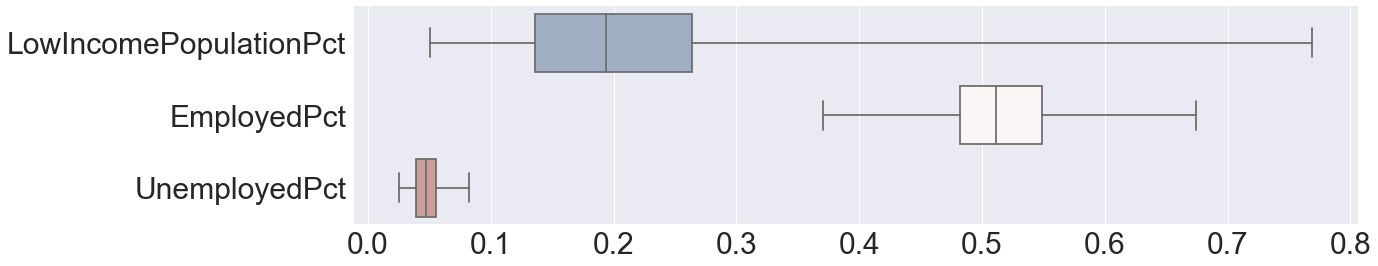

In [5]:
sns.set(font_scale=3) 
f, ax = plt.subplots(figsize=(18, 4))
sns.boxplot(data=toronto2014.loc[:,['LowIncomePopulationPct','EmployedPct','UnemployedPct']]
             , whis="range", palette="vlag", orient="h")
plt.savefig("PercentageOfPopulation_boxplot")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109780550>,
      dtype=object)

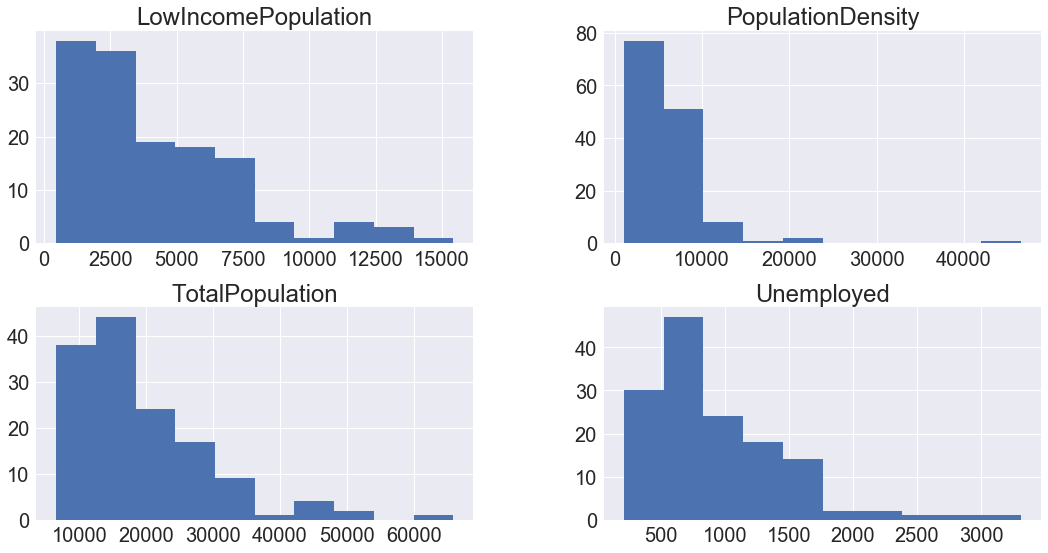

In [6]:
sns.set(font_scale=2) 
toronto2014.hist(column=['TotalPopulation','PopulationDensity','Unemployed','LowIncomePopulation']
                , figsize=(18,9))

#### Exploratory Visualization

In the pair plots below, the population density does not demonstrate a linear relationship with crime. It is therefore dropped from further analysis.

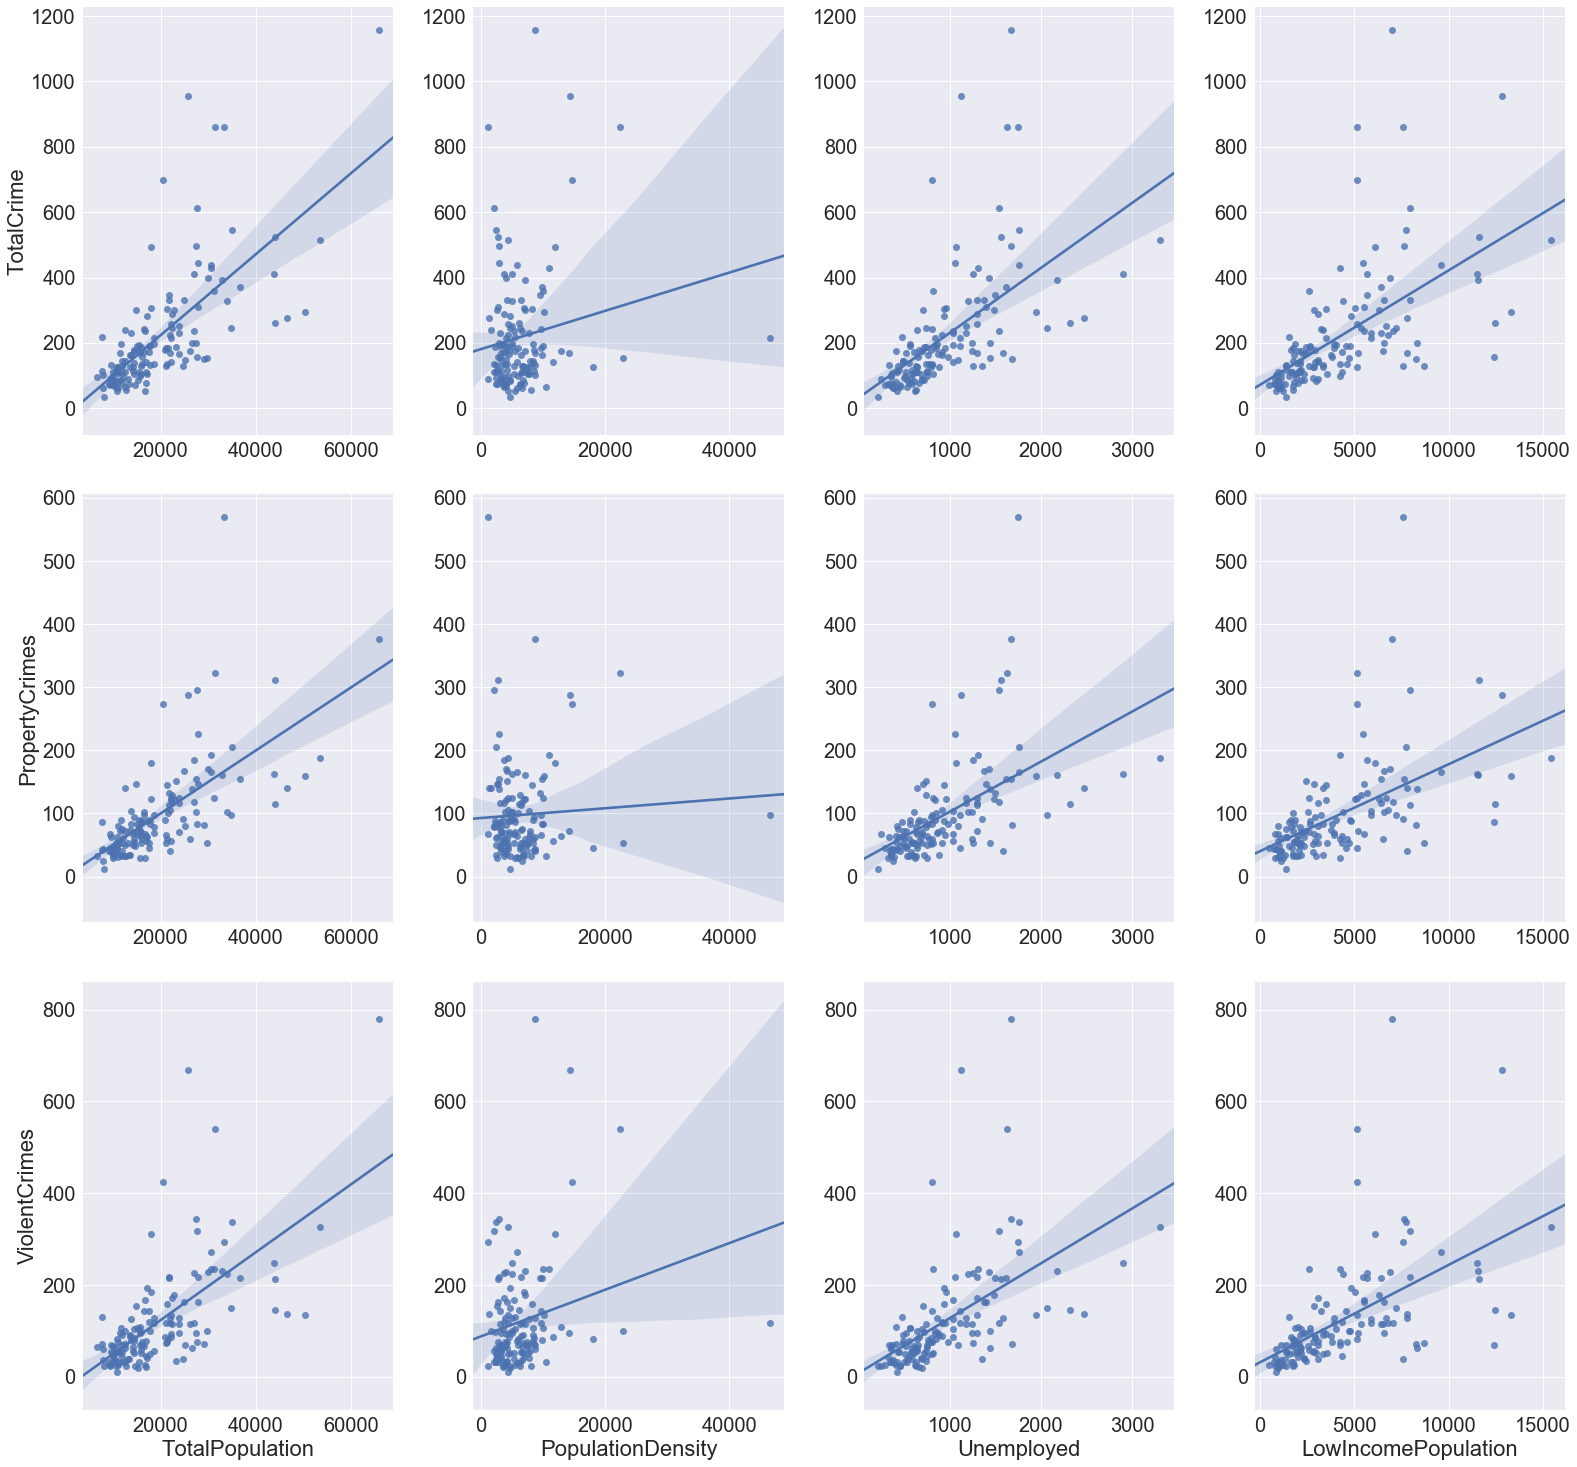

In [7]:
sns.pairplot(toronto2014, x_vars=['TotalPopulation','PopulationDensity','Unemployed','LowIncomePopulation']
            , y_vars=['TotalCrime','PropertyCrimes','ViolentCrimes']
            , size=7, aspect=0.8, kind='reg')
plt.savefig("Crime_Pairplot")

#### Defining the scope of the linear regression models

To evaluate whether focus should be on specific crime(s) or overall crime statistics, linear regression models are fitted for each type and 3 aggregate numbers, using predictors:

1. The number of low income population in the ward
2. The number of population in labour force and working
3. The number of unemployed population
4. The total population of the ward

In [8]:
Crimes = ['TotalCrime','PropertyCrimes','ViolentCrimes','BreakEnters', 'Robberies','VehicleThefts','Thefts','Arsons','Assaults','SexualAssaults','Murders']

In [9]:
AdjRSquares = pd.DataFrame(index=Crimes
                           , columns=['LowIncomePopulation','InLabourForce','Unemployed','ThreeEconPredictors'
                                      ,'TotalPopulation','PopulationAndEconPredictors'])

In [10]:
for t in Crimes:
    m1 = ols(t + " ~ LowIncomePopulation", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'LowIncomePopulation'] = m1.rsquared_adj
    m2 = ols(t + " ~ InLabourForce", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'InLabourForce'] = m2.rsquared_adj
    m3 = ols(t + " ~ Unemployed", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'Unemployed'] = m3.rsquared_adj
    m4 = ols(t + " ~ LowIncomePopulation + InLabourForce + Unemployed", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'ThreeEconPredictors'] = m4.rsquared_adj
    m5 = ols(t + " ~ TotalPopulation", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'TotalPopulation'] = m5.rsquared_adj
    m6 = ols(t + " ~ LowIncomePopulation + Unemployed + TotalPopulation", data=toronto2014).fit()
    AdjRSquares.loc[AdjRSquares.index == t, 'PopulationAndEconPredictors'] = m6.rsquared_adj

In [11]:
AdjRSquares

,LowIncomePopulation,InLabourForce,Unemployed,ThreeEconPredictors,TotalPopulation,PopulationAndEconPredictors
TotalCrime,0.348345,0.446824,0.342122,0.490078,0.474709,0.490206
PropertyCrimes,0.304271,0.419008,0.307201,0.450627,0.435418,0.444606
ViolentCrimes,0.318338,0.389756,0.307021,0.43169,0.420447,0.435506
BreakEnters,0.185714,0.465896,0.221852,0.509053,0.442033,0.481333
Robberies,0.323687,0.246661,0.315273,0.341607,0.27801,0.340818
VehicleThefts,0.14381,0.129116,0.129896,0.152987,0.150071,0.156806
Thefts,0.20286,0.367733,0.170103,0.453206,0.369411,0.437614
Arsons,0.123183,0.140565,0.124436,0.147756,0.148823,0.145436
Assaults,0.326577,0.3982,0.320758,0.438848,0.432478,0.44573
SexualAssaults,0.202183,0.268895,0.15814,0.329262,0.270346,0.305715


#### Notes

With the exception of modelling break and enter crimes with the economic predictors, the linear regression model is most accurate in predicting total crime. The correlation with property alone is not as strong as one would assume.

### Linear Regression Analysis

First model is based only on the low income population, the adjusted R-squared is rather low at 0.348. But both the coefficient's and the intercept's p-values are under 0.05.

The outliers with more crime than model predicts are:
1. Bay Street Corridor
2. Church-Yonge Corridor
3. West Humber-Clairville
4. Moss Park
5. York University Heights

                            OLS Regression Results                            
Dep. Variable:             TotalCrime   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     75.30
Date:                Sun, 22 Jul 2018   Prob (F-statistic):           1.01e-14
Time:                        10:27:55   Log-Likelihood:                -894.30
No. Observations:                 140   AIC:                             1793.
Df Residuals:                     138   BIC:                             1798.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              71.7478    

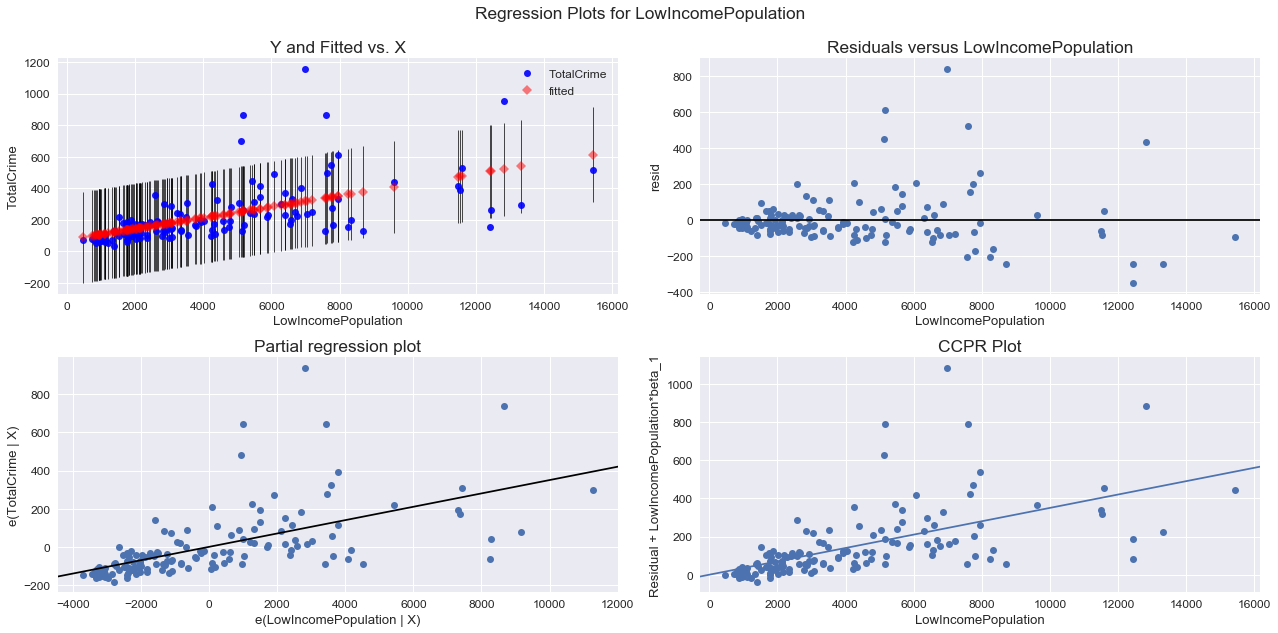

In [12]:
model_allcrime_lowincome = ols("TotalCrime ~ LowIncomePopulation", data=toronto2014).fit()
print(model_allcrime_lowincome.summary())

sns.set(font_scale=1.2)
fig = plt.figure(figsize=(18,9))
fig = sm.graphics.plot_regress_exog(model_allcrime_lowincome, "LowIncomePopulation", fig=fig)
plt.savefig("Crime_LowIncome")

The second model uses employed population instead and the r-squared improved. However the intercept is no longer significant.

                            OLS Regression Results                            
Dep. Variable:             TotalCrime   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     113.3
Date:                Sun, 22 Jul 2018   Prob (F-statistic):           1.10e-19
Time:                        10:27:56   Log-Likelihood:                -882.83
No. Observations:                 140   AIC:                             1770.
Df Residuals:                     138   BIC:                             1776.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -20.2858     25.038     -0.810

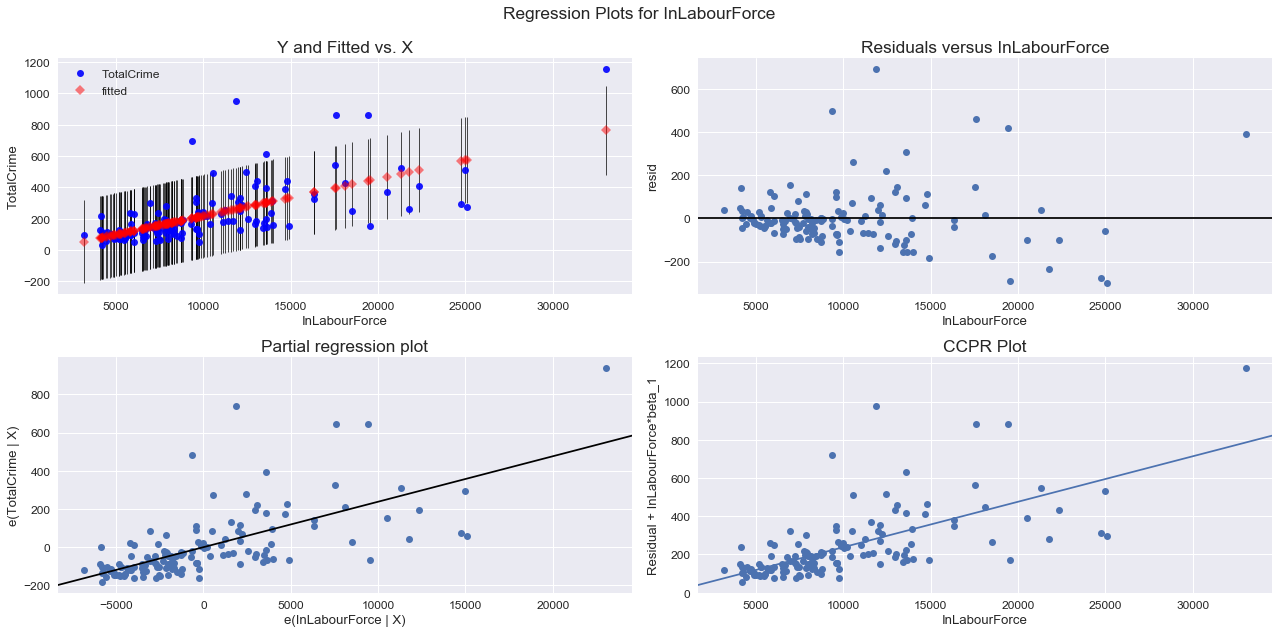

In [13]:
model_allcrime_employed = ols("TotalCrime ~ InLabourForce", data=toronto2014).fit()
print(model_allcrime_employed.summary())

fig = plt.figure(figsize=(18,9))
fig = sm.graphics.plot_regress_exog(model_allcrime_employed, "InLabourForce", fig=fig)
plt.savefig("Crime_Employed")

Similar can be said for the 3rd linear regression model, this time using unemployed population. R-squared is much lower than using low income population as a predictor.

                            OLS Regression Results                            
Dep. Variable:             TotalCrime   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     73.29
Date:                Sun, 22 Jul 2018   Prob (F-statistic):           1.95e-14
Time:                        10:27:57   Log-Likelihood:                -894.96
No. Observations:                 140   AIC:                             1794.
Df Residuals:                     138   BIC:                             1800.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.8290     24.947      1.276      0.2

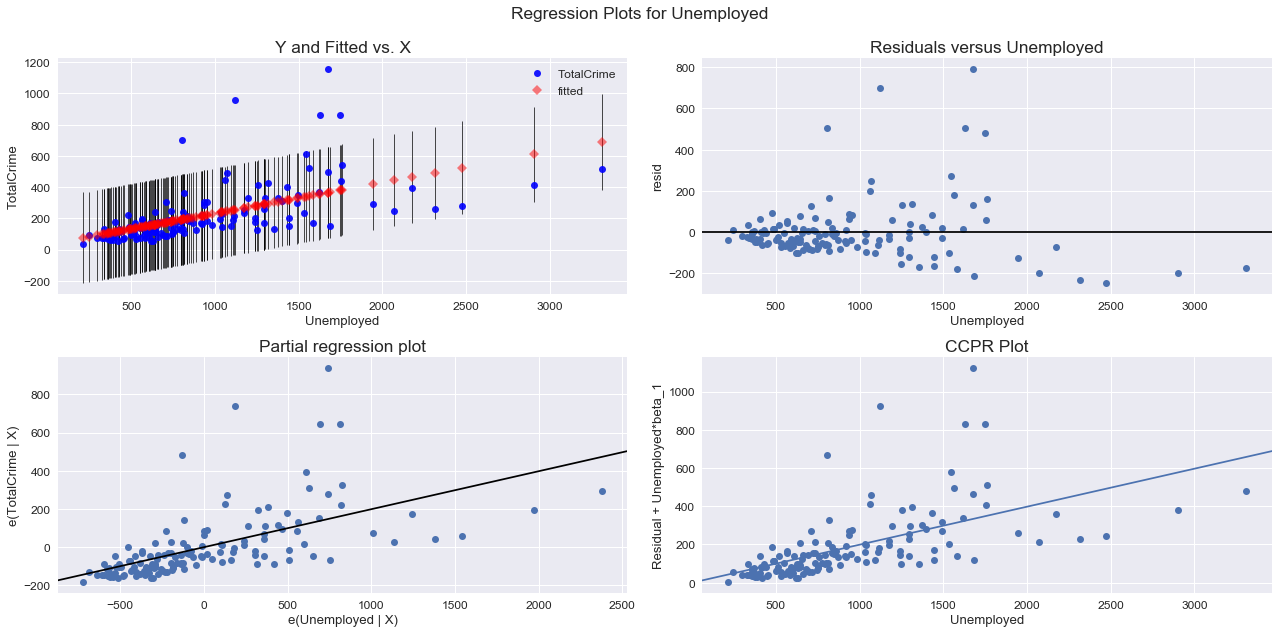

In [14]:
model_allcrime_unemployed = ols("TotalCrime ~ Unemployed", data=toronto2014).fit()
print(model_allcrime_unemployed.summary())

fig = plt.figure(figsize=(18,9))
fig = sm.graphics.plot_regress_exog(model_allcrime_unemployed, "Unemployed", fig=fig)
plt.savefig("Crime_Unemployed")

Fourth model is multi-variate linear regression, using all 3 economic statistics. The adjusted R-squared increased with the addition of new variables, and the p-values for all 3 coefficients are significant.

                            OLS Regression Results                            
Dep. Variable:             TotalCrime   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     45.53
Date:                Sun, 22 Jul 2018   Prob (F-statistic):           1.95e-20
Time:                        10:27:58   Log-Likelihood:                -876.11
No. Observations:                 140   AIC:                             1760.
Df Residuals:                     136   BIC:                             1772.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -16.7191    

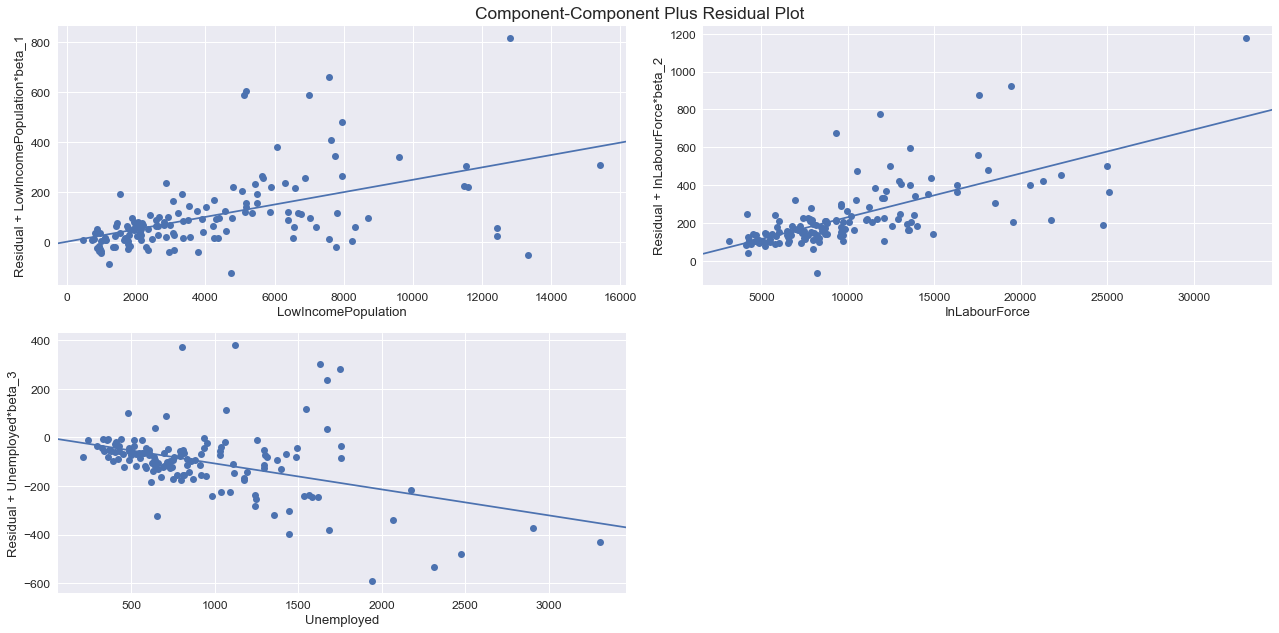

In [15]:
model_allcrime_econ = ols("TotalCrime ~ LowIncomePopulation + InLabourForce + Unemployed", data=toronto2014).fit()
print(model_allcrime_econ.summary())

fig = plt.figure(figsize=(18,9))
fig = sm.graphics.plot_ccpr_grid(model_allcrime_econ, fig=fig)
plt.savefig("Crime_Economics")

In the fifth and final model, popultion is also added as a predictor. While the adjusted R-squared remain almost exactly the same, the coefficient p-values are no longer under 0.05. There is also a risk of overfitting since the total population is equal to employed population + unemployed population + population not in labour force.

                            OLS Regression Results                            
Dep. Variable:             TotalCrime   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     34.38
Date:                Sun, 22 Jul 2018   Prob (F-statistic):           8.94e-20
Time:                        10:27:59   Log-Likelihood:                -875.61
No. Observations:                 140   AIC:                             1761.
Df Residuals:                     135   BIC:                             1776.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -17.4064    

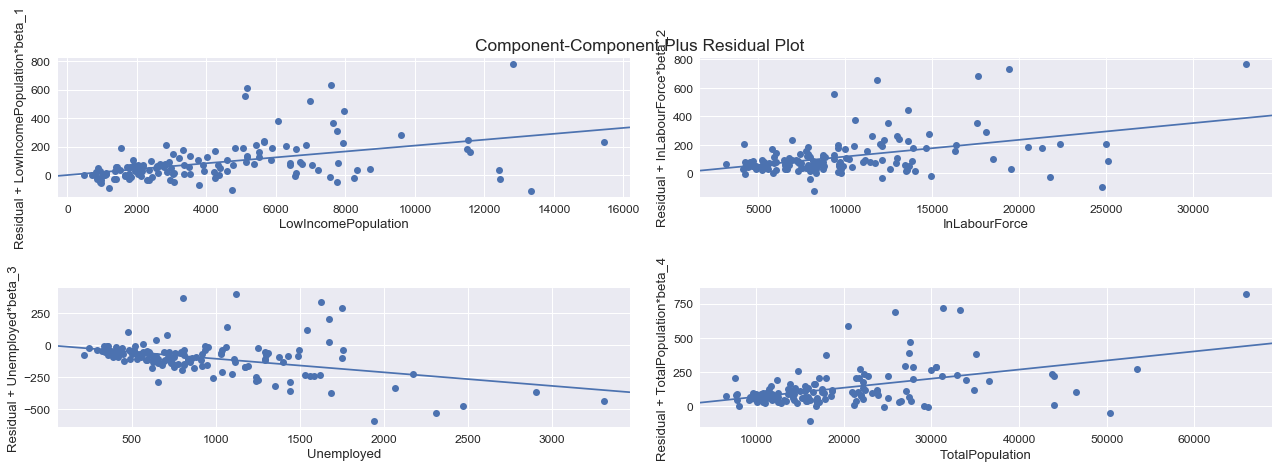

In [16]:
model_allcrime_econdemo = ols("TotalCrime ~ LowIncomePopulation + InLabourForce + Unemployed + TotalPopulation", data=toronto2014).fit()
print(model_allcrime_econdemo.summary())

fig = plt.figure(figsize=(18,9))
fig = sm.graphics.plot_ccpr_grid(model_allcrime_econdemo, fig=fig)
plt.savefig("Crime_EconPop")

#### Effect of outliers

Reverting back to using only economic demographic statistics (low income population, working population, unemployed popution), below evaluates the outliers.

Given the Waterfront Communities-The Island ward has 23% higher population than the second most populated ward in Toronto, the leverage is very high on the far end of all population x-axes. To ensure the model can be parametized to predict crime for a typical neighbourhood, the outlier is removed.

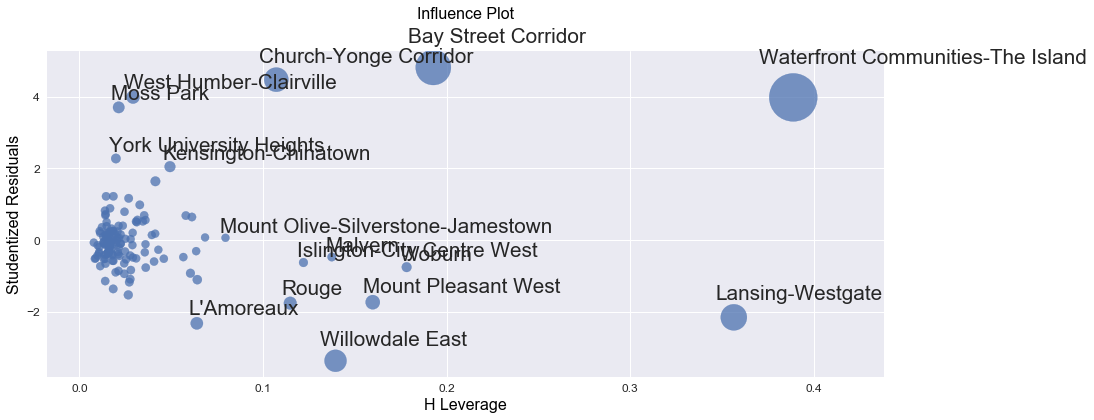

In [17]:
fig, ax = plt.subplots(figsize=(15,6))
plt.title("", y=1.08)
fig = sm.graphics.influence_plot(model_allcrime_econdemo, ax=ax)
plt.savefig("InfluencePlotAll")

Without this high-leverage point, the OLS regression model shows a drop in adjusted R-squared. The model results also reveals that the chosen statistics are not the ideal predictors for total crime in a city ward.

                            OLS Regression Results                            
Dep. Variable:             TotalCrime   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     36.32
Date:                Sun, 22 Jul 2018   Prob (F-statistic):           2.83e-17
Time:                        10:54:41   Log-Likelihood:                -862.18
No. Observations:                 139   AIC:                             1732.
Df Residuals:                     135   BIC:                             1744.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              13.8775    

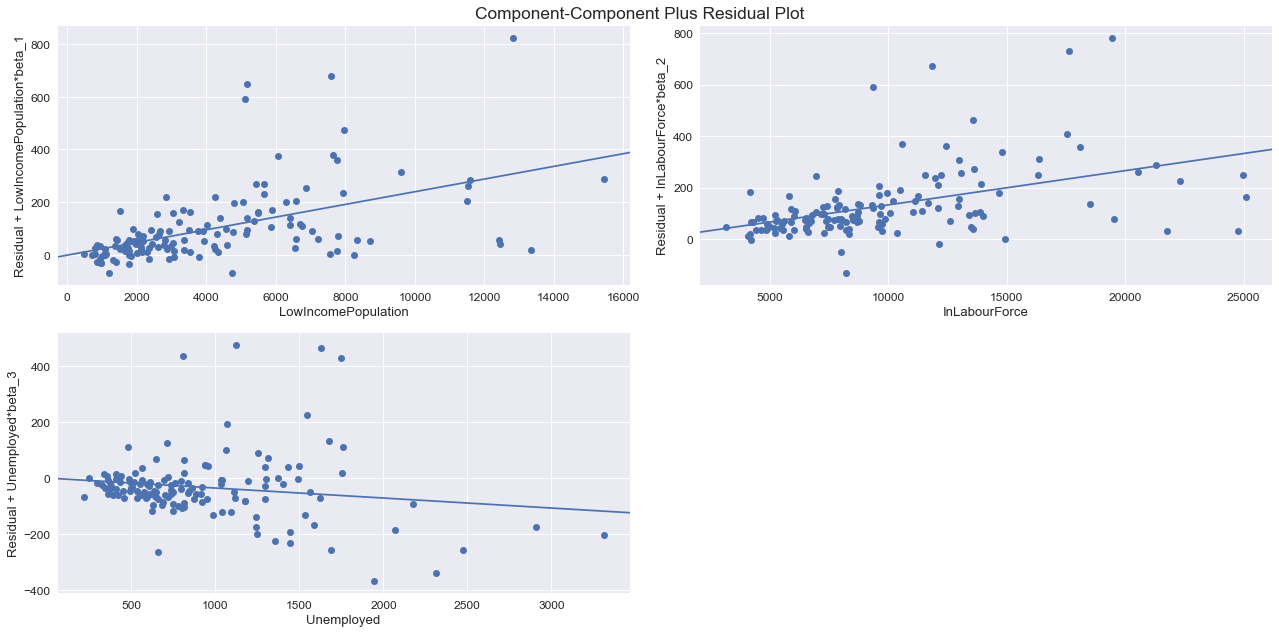

In [19]:
subset = ~toronto2014.index.isin(["Waterfront Communities-The Island"])

model_allcrime_econ2 = ols("TotalCrime ~ LowIncomePopulation + InLabourForce + Unemployed", data=toronto2014, subset=subset).fit()
print(model_allcrime_econ2.summary())

fig = plt.figure(figsize=(18,9))
fig = sm.graphics.plot_ccpr_grid(model_allcrime_econ2,fig=fig)
plt.savefig("InfluencePlotWithoutWaterfront")